# Nonlinear Regression of the Counter-Current Heat Exchanger Model
#### Khaled Aleikish and Bernt Lie
#### University of South-Eastern Norway
#### Porsgrunn, April 2020

## Preliminaries
### Packages

In [1]:
using DifferentialEquations
using LaTeXStrings
using Plots; pyplot(); # here, pyplot is used as a back-end to the Plots API
using Plots.PlotMeasures
using Flux
using ProgressMeter
using Combinatorics
using BSON: @save
using StatsBase

|Package|Link|
|:---|:------------|
|DifferentialEquations|https://github.com/SciML/DiffEqDocs.jl/blob/master/docs/src/index.md|
|LaTeXStrings|https://github.com/stevengj/LaTeXStrings.jl|
|Plots|https://github.com/JuliaPlots/Plots.jl|
|PyPlot|https://github.com/JuliaPy/PyPlot.jl|
|Flux|https://github.com/FluxML/Flux.jl|
|ProgressMeter|https://github.com/timholy/ProgressMeter.jl|
|Combinatorics|https://github.com/JuliaMath/Combinatorics.jl|
|BSON|https://github.com/JuliaIO/BSON.jl|
|StatsBase|https://github.com/JuliaStats/StatsBase.jl|

### Utility parameters

In [2]:
# Plot parameters
LW1 = 2.5
LW2 = 1.5
LW3 = 1
LS1 = :solid
LS2 = :dot
LS3 = :dash
LS4 = :dashdot
LA1 = 1
LA2 = 0.7
LA3 = 0.4
# File system paths
#
# Figures are stored in this path.
Figpath = "C:\\Users\\kolds\\Dropbox\\Master's_Thesis\\MSc_Report_Lyx\\fig\\Simulation_Results\\Jupyter_Notebook_4\\" 
;

### Utility functions

In [3]:
# BL Utility functions
#
# Normalization function
function normalize(X)
    Xmin = minimum(X,dims=2)
    Xmax = maximum(X,dims=2)
    Xnorm = (X .- Xmin)./(Xmax-Xmin)
    denormalize = (Xnorm,Xmin,Xmax) -> Xnorm.*(Xmax-Xmin).+Xmin
    return Xnorm, Xmin,Xmax,denormalize
end
;

In [4]:
# This function runs the Holdout method multiple times and returns an average RMSE
function multiple_Holdout(TTAgrid,TTNgrid,nW,ngrid,ratio,j,N_epochs)
    RMSE_Array = Array{Float64}(undef, j,length(nW),2);
    avg_RMSE_1 = Array{Float64}(undef, 1,length(nW))
    avg_RMSE_2 = Array{Float64}(undef, 1,length(nW))    
    for v in 1:j
        ############################# Sampling #############################
        #
        # Preparing the data set for sampling
        #
        Twh_A_N =(hcat(TTAgrid'[:,1],TTNgrid'[:,1]))'
        Tac_A_N =(hcat(TTAgrid'[:,2],TTNgrid'[:,2]))'
        #
        # Constructing training & testing samples indices
        #
        Train_index =  sort!(StatsBase.sample(1:ngrid, convert(Int64, round(ratio*ngrid)), replace=false))
        #
        Test_index = [i for i in 1:ngrid]
        for i in Train_index
            k = findall(x->x==i,Test_index)
            Test_index = Test_index[1:end .!= k, 1]
        end
        #
        # Constructing training & testing samples
        #
        Train_Sample_Twh = Twh_A_N[:,Train_index[:]]
        Train_Sample_Tac = Tac_A_N[:,Train_index[:]]
        Test_Sample_Twh = Twh_A_N[:,Test_index[:]]
        Test_Sample_Tac = Tac_A_N[:,Test_index[:]]
        #
        # Reconstructing TTAgrid & TTNgrid from samples
        #
        TTAgrid_Train_Sample=[Train_Sample_Twh[1,:] Train_Sample_Tac[1,:]]'
        TTNgrid_Train_Sample=[Train_Sample_Twh[2,:] Train_Sample_Tac[2,:]]'
        TTAgrid_Test_Sample=[Test_Sample_Twh[1,:] Test_Sample_Tac[1,:]]'
        TTNgrid_Test_Sample=[Test_Sample_Twh[2,:] Test_Sample_Tac[2,:]]'
        #
        ####################### Nonlinear regression #######################
        #
        X = TTAgrid_Train_Sample
        Y = TTNgrid_Train_Sample
        #
        # First, the data is normalized (The values in the Arrays X & Y are changed to a common scale [0,1]).
        Xn,Xmin,Xmax,X_denorm = normalize(X)[1],normalize(X)[2],normalize(X)[3],normalize(X)[4]
        Yn,Ymin,Ymax,Y_denorm = normalize(Y)[1],normalize(Y)[2],normalize(Y)[3],normalize(Y)[4]
        # Then, the data is placed in the `data` Array, where it will be passed as an argument to train! later on.
        data = [(Xn,Yn)]
        #
        ny = size(Yn,1)
        nx = size(Xn,1)
        #
        # Construct models with different number of weights and train them.
        #
        for h in 1:length(nW)
            out = nW[h]
            #
            model = Chain(
            Dense(nx, out, σ),
            Dense(out, ny))
            p = params(model)
            opt = Descent(0.1)
            ŷ(Xn) =  model(Xn)
            loss(Xn, Yn) = Flux.mse(ŷ(Xn), Yn)
            #
            for i in 1:N_epochs#*out
                Flux.train!(loss, p, data, opt)
            end
            Y_hat=Y_denorm(ŷ(Xn),Ymin,Ymax);
            RMSE(Y,ŷ) = sqrt(sum((ŷ .- Y).^2)/length(Y))
            RMSE_Array[v,h,1]=RMSE(Y[1,:],Y_hat[1,:])
            RMSE_Array[v,h,2]=RMSE(Y[2,:],Y_hat[2,:])
            println(h, " model out of ", length(nW)," done\n") 
        end
        println(v, " sample out of ", j," done\n\n")            
    end
    #
    #
    for h in 1:length(nW) 
        avg_RMSE_1[h] = sum(RMSE_Array[:,h,1])/j
        avg_RMSE_2[h] = sum(RMSE_Array[:,h,2])/j
    end
    #
    println("The average RMSE for Y1: ", avg_RMSE_1,"\nThe average RMSE for Y2: ", avg_RMSE_2)
    return avg_RMSE_1,avg_RMSE_2
end
;

In [5]:
# This function runs the Holdout method multiple times and returns an average RMSE
function multiple_Holdout_c3_b(TTAgrid,TTNgrid,nW,ngrid,ratio,j,N_epochs)
    RMSE_Array = Array{Float64}(undef, j,length(nW),2);
    avg_RMSE_1 = Array{Float64}(undef, 1,length(nW))
    avg_RMSE_2 = Array{Float64}(undef, 1,length(nW))    
    for v in 1:j
        ############################# Sampling #############################
        #
        # Preparing the data set for sampling
        #
        Md_w_a = (hcat(TTAgrid'[:,3],TTAgrid'[:,4]))'
        Twh_A_N =(hcat(TTAgrid'[:,1],TTNgrid'[:,1]))'
        Tac_A_N =(hcat(TTAgrid'[:,2],TTNgrid'[:,2]))'
        #
        # Constructing training & testing samples indices
        #
        Train_index =  sort!(StatsBase.sample(1:ngrid, convert(Int64, round(ratio*ngrid)), replace=false))
        #
        Test_index = [i for i in 1:ngrid]
        for i in Train_index
            k = findall(x->x==i,Test_index)
            Test_index = Test_index[1:end .!= k, 1]
        end
        #
        # Constructing training & testing samples
        #
        Train_Sample_Md = Md_w_a[:,Train_index[:]]
        Test_Sample_Md = Md_w_a[:,Test_index[:]]
        Train_Sample_Twh = Twh_A_N[:,Train_index[:]]
        Train_Sample_Tac = Tac_A_N[:,Train_index[:]]
        Test_Sample_Twh = Twh_A_N[:,Test_index[:]]
        Test_Sample_Tac = Tac_A_N[:,Test_index[:]]
        #
        # Reconstructing TTAgrid & TTNgrid from samples
        #
        TTAgrid_Train_Sample=[Train_Sample_Md[1,:] Train_Sample_Md[2,:] Train_Sample_Twh[1,:] Train_Sample_Tac[1,:]]'
        TTNgrid_Train_Sample=[Train_Sample_Twh[2,:] Train_Sample_Tac[2,:]]'
        TTAgrid_Test_Sample=[Test_Sample_Md[1,:] Test_Sample_Md[2,:] Test_Sample_Twh[1,:] Test_Sample_Tac[1,:]]'
        TTNgrid_Test_Sample=[Test_Sample_Twh[2,:] Test_Sample_Tac[2,:]]'
        #
        ####################### Nonlinear regression #######################
        #
        X = TTAgrid_Train_Sample
        Y = TTNgrid_Train_Sample
        #
        # First, the data is normalized (The values in the Arrays X & Y are changed to a common scale [0,1]).
        Xn,Xmin,Xmax,X_denorm = normalize(X)[1],normalize(X)[2],normalize(X)[3],normalize(X)[4]
        Yn,Ymin,Ymax,Y_denorm = normalize(Y)[1],normalize(Y)[2],normalize(Y)[3],normalize(Y)[4]
        # Then, the data is placed in the `data` Array, where it will be passed as an argument to train! later on.
        data = [(Xn,Yn)]
        #
        ny = size(Yn,1)
        nx = size(Xn,1)
        
        # Construct models with different number of weights and train them.
        #
        for h in 1:length(nW)
            out = nW[h]
            #
            model = Chain(
            Dense(nx, out, σ),
            Dense(out, ny))
            p = params(model)
            opt = Descent(0.1)
            ŷ(Xn) =  model(Xn)
            loss(Xn, Yn) = Flux.mse(ŷ(Xn), Yn)
            #
            for i in 1:N_epochs#*out
                Flux.train!(loss, p, data, opt)
            end
            Y_hat=Y_denorm(ŷ(Xn),Ymin,Ymax);
            RMSE(Y,ŷ) = sqrt(sum((ŷ .- Y).^2)/length(Y))
            RMSE_Array[v,h,1]=RMSE(Y[1,:],Y_hat[1,:])
            RMSE_Array[v,h,2]=RMSE(Y[2,:],Y_hat[2,:])
            println(h, " model out of ", length(nW)," done\n") 
        end
        println(v, " sample out of ", j," done\n\n")            
    end
    #
    #
    for h in 1:length(nW) 
        avg_RMSE_1[h] = sum(RMSE_Array[:,h,1])/j
        avg_RMSE_2[h] = sum(RMSE_Array[:,h,2])/j
    end
    #
    println("The average RMSE for Y1: ", avg_RMSE_1,"\nThe average RMSE for Y2: ", avg_RMSE_2)
    return avg_RMSE_1,avg_RMSE_2
end

multiple_Holdout_c3_b (generic function with 1 method)

## Heat exchanger description
The parameters and operational data are based on the model of Åbjøra reactor in "Solution, Project, FM1015 Modelling of Dynamic Systems" by Bernt Lie. November 16, 2018.

### Thermo-physical and geometrical data

In [6]:
# Parameters
#
const chpa = 1.15	# Specific heat capacity of air, kJ.kg-1.K-1
const chpw = 4.2	# Specific heat capacity of water, kJ.kg-1.K-1

const hAax = 55.6	# Heat transfer, air side heat exchanger, kW/K
const hAwx = 222	# Heat transfer, water side heat exchanger, kW/K
const UAx = 1 / (1 / hAax + 1 / hAwx)	# Overall Heat transfer, heat exchanger, kW/K
#
# Heat exchanger length
# const Lx = 1.0 # x = 0 to 1 , Simpler, gives a relative position and can be omitted from the heat exchanger model.
;

In [7]:
# BL heat capacities
function cp_a(x)
    cp_a0 = 1.007
    y = x+273.15
    y0 = 300
    return cp_a0*(299.94 + 1.008*(y-y0)+1.2e-4*(y-y0)^2+5.9e-7*(y-y0)^3+2.56e-9*(y-y0)^4)/y
end
#
function cp_w(x)
    cp_w0 = 4.179
    y = x+273.15
    y0 = 300
    return cp_w0*(0.9998-6.6e-5*(y-y0) + 6.39e-6*(y-y0)^2-1.145e-7*(y-y0)^3+8.9e-10*(y-y0)^4)
end
;

### Operational data

In [8]:
# Inputs
Twc = 3.8	# Cold water temperature, C
Tah = 39.12	# Hot air temperature, C
mdw = 53.9	# Heat exchanger water mass flow rate, kg/s
mda = 49.2	# Heat exchanger air mass flow rate, kg/s
;

## Heat Exchanger models
### Analytic model
This model is based on Modeling of Dynamic Systems lecture notes by Bernt Lie. August 16, 2019.

In [9]:
function hex_a(inputs,par,x) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))    
    Tw(x) = ((NStw*exp(-NStd*x)-NSta)*Twc+(NStw - NStw*exp(-NStd*x))*Tac)/NStd
    Ta(x) = ((NSta*exp(-NStd*x)-NSta)*Twc+(NStw - NSta*exp(-NStd*x))*Tac)/NStd
    return [Tw(x), Ta(x)]
end
;

### Numeric boundary value model
This model solves the nonlinear two-point boundary value problem for the case of temperature dependence in the specific heat capacities of air and water.

The boundary value differential equation solver is wrapped in a function to mimic the form of `Analytic_HeatExchanger()`

In [10]:
function hex_n(inputs,par,x) 
    # The function for the ODE.
    function hex_i!(dy,y,par,x)
        # Interior of heat exchanger with temperature dependent heat capacity
        mdw, mda = par[3],par[4]
        UAx, cp_w, cp_a = par[5],par[6],par[7]
        #
        Tw,Ta = y
        dy[1] = -UAx/(mdw*cp_w(Tw))*(Tw - Ta)
        dy[2] = -UAx/(mda*cp_a(Ta))*(Tw - Ta)
    end
    #
    # Boundaries of heat exchanger with temperature dependent heat capacity
    function hex_b!(residual, y, par, x)
        Twc,Tah = par[1],par[2]
        residual[1] = y[1][1]-Twc
        residual[2] = y[end][2]-Tah
    end
    #
    u0 = [3.0, 19.0] # The initial condition.
    prob_hex = BVProblem(hex_i!, hex_b!, u0, x, [inputs  par])
    sol_hex = solve(prob_hex, Shooting(Vern7()), dtmax=0.01)
    return sol_hex
end
;

In [11]:
# Parameters are passed to functions in an Array to avoid problems associated with global variables.
par_hex_a = [UAx chpw chpa]
par_hex_n = [UAx cp_w cp_a] # Here, cp_w and cp_a are functions.
#
# Inputs are passed to functions in an Array to avoid problems associated with global variables.
u_hex = [Twc Tah mdw mda]
#
# The spatial span for the problem.
xspan_a = collect(0:0.01:1)
xspan_n = (0.0, 1.0) 
;

### Case III: variable temperatures (`Twc` & `Tah`) and mass flow rates (`mdw` & `mda`). (A) Mass flow rates are generated in the same range as case (2.a), and influent temperatures are generated in the same range as case 1.
#### Generating the dataset

In [12]:
# Experimental ranges
n_Tw = 5
n_Ta = 5
n_mdw = 5
n_mda = 5
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,30.,length=n_Tw)
r_Tah = range(40.,100.,length=n_Ta)
r_mdw = range(40.,100.,length=n_mdw)
r_mda = range(40.,100.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_a = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c3_a = Matrix{Float64}(undef,2,ngrid)
;

In [13]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_a[:,i] .= [sol_analytic[end][1],sol_analytic[1][2]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_a[:,i] .= [sol_numeric[end][1],sol_numeric[1][2]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


#### Model Training
Model training is based on information obtained from Flux documentation at https://fluxml.ai/Flux.jl/stable/.

`train!` requires the following:

1. Datasets.
2. A set of tracked parameters.
3. The loss function.
4. An optimiser.

Also, an additional argument could be passed to `train!` to  observe the training process.
##### Datasets
It is possible to generate more datasets using different operating conditions (`Twc`, `Tah`, `mdw`, `mda`). Then, `data = [(Xn1, Yn1), (Xn2, Yn3), (Xn3, Yn3)]`. 

In [14]:
X = TTAgrid_c3_a
Y = TTNgrid_c3_a
#
# First, the data is normalized (The values in the Arrays X & Y are changed to a common scale [0,1]).
Xn,Xmin,Xmax,X_denorm = normalize(X)[1],normalize(X)[2],normalize(X)[3],normalize(X)[4]
Yn,Ymin,Ymax,Y_denorm = normalize(Y)[1],normalize(Y)[2],normalize(Y)[3],normalize(Y)[4]
# Then, the data is placed in the `data` Array, where it will be passed as an argument to train! later on.
data = [(Xn,Yn )] # |> gpu
# Loading the data on the gpu requires the following:
# using CuArrays
# using CUDAdrv, CUDAnative, CuArrays # The three core packages for CUDA
# According to the benchmark results, the CPU is faster although memory usage is higher.
;

##### Model
This model consists of two linear layers with a nonlinearity (σ) in between them.

Here, the layers could have been generated using the syntax:

`layer_1(x) = W1 * X .+ B1`

`layer_2(x) = W2 * X .+ B2`

`model(x) = layer_2(σ.(layer_1(x)))`,

but, the `Dense` layer is used instead, where each layer consist of:

$\hat{\mathbf{Y}}$= $\mathbf{W}\mathbf{X}$ .+ $\mathbf{b}$.

The `Dense` layer takes the following arguments:

1. Input size (${in}$). The input matrix ${\mathbf{X}}$ must be of size ${in \times n}$ (${row \times column}$). 
2. Output size (${out}$). The output matrix ${\hat{\mathbf{Y}}}$ of the `Dense` layer will be of size ${out \times n}$.
3. Activation functions like (σ).

`Dense(in::Integer, out::Integer, σ = identity)`

If the matrix ${\mathbf{Y}}$ consist of ${\mathrm{m}}$ regressands and ${\mathrm{n}}$ observation, and the Data matrix ${\mathbf{X}}$ consist of (${in}$) regressors and ${\mathrm{n}}$ observation, then the output ${\hat{\mathbf{Y}}_1}$ of the first `Dense` layer:

${\hat{\mathbf{Y}}_1}$: ${out \times n}$

=

${\mathbf{W}_1}$: ${out \times in}$

${\mathbf{X}}$: ${in\times n}$

.+

${\mathbf{b}_1}$: ${out\times 1}$,

The second `Dense` layer takes the input size of ${out}$ of ${\hat{\mathbf{Y}}_1}$ and the output size ${\mathrm{m}}$ of the matrix ${\hat{\mathbf{Y}}_2= \mathbf{Y}}$:

${\hat{\mathbf{Y}}_2}$: ${m \times n}$

=

${\mathbf{W}_2}$: ${m \times out}$

${\mathbf{X}}$ = ${\hat{\mathbf{Y}}_1}$: ${out \times n}$

.+

${\mathbf{b}_2}$: ${m\times 1}$,

The `Chain(layers...)` is used to bind the layers together and form the model as in `model(x) = layer_2(σ.(layer_1(x)))`

$\mathbf{Example:}$

Taking the generated $\mathbf{X}$ and $\mathbf{Y}$ from the simulation of sizes $2\times 625$ (here, $in = m= 2$), the first `Dense` layer is formed by `Dense(2, out)`. and the second layer is formed by `Dense(out, 2)`.

In [15]:
ny = size(Yn,1)
nx = size(Xn,1)
out = 75 # An arbitrary number.
#
model = Chain(
    Dense(nx, out, σ),
    Dense(out, ny)) # |> gpu
;

`params(model)` is used to obtain the model tracked parameters:

In [16]:
p = Flux.params(model) ;

##### Optimizer 
To train the model, the optimizer update the model parameters/weights to reduce the error/loss.

Here, the classic gradient descent optimizer is used:

`Descent(η)`: 

W .-= η .* W̄

Alternatively, an advanced optimizer such as `ADAM` can be used:

`opt = ADAM(0.001, (0.9, 0.999))`

In [17]:
opt = Descent(0.1);

#### The loss function 
Flux have a number of Cost Functions that measure the error in predication. Here, the mean squared error is used.

In [18]:
ŷ(Xn) =  model(Xn) 
loss(Xn, Yn) = Flux.mse(ŷ(Xn) , Yn);

# Alternatively,
#
# function loss_2(Xn, Yn)
#   sum((ŷ(Xn) .- Yn).^2)/length(Yn)
# end

##### Callbacks

In [19]:
function cb_stop(i,n)
    if loss(Xn, Yn) < n
         @show(i,loss(Xn, Yn))
         throw(TargetReached!)
    end
end
#
# cb_1(Epoch) =  @show(Epoch,loss(Xn, Yn))
#
# cb_2 = function()
#     @show(loss(Xn, Yn))
#     #
#     plot(Xn[1,:],Xn[2,:],ŷ(Xn)[1,:],seriestype=:surface)
#     scatter!(Xn[1,:],Xn[2,:],Yn[1,:],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"Normalized Data for $T_{\mathrm{w}}^{\mathrm{h}}$",color="red")
#     fg1= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$")
#     plot(Xn[1,:],Xn[2,:],ŷ(Xn)[2,:],seriestype=:surface)
#     scatter!(Xn[1,:],Xn[2,:],Yn[1,:],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"Normalized Data for $T_{\mathrm{a}}^{\mathrm{c}}$",color="#00FFFF")
#     fg2= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$")
#     # 
#     Fig = plot(fg1,fg2,layout=grid(2,1),size = (600, 1000),framestyle = :box,bottom_margin=10mm) |> display 
# end
;

##### Training the model>

It is possible to create a custom training loop, but using `Flux.train!` is more convenient.

`For` loop is used to loop over `Flux.train!` instead of `@epochs`.

In [20]:
N_epochs = 50000 # The number of epochs
for i in 1:N_epochs
#     Flux.train!(loss, p, data, opt,cb = cb = () -> cb_stop(i,0.0001))
    Flux.train!(loss, p, data, opt)
end

##### RMSE

In [21]:
RMSE(Y,ŷ) = sqrt(sum((ŷ .- Y).^2)/length(Y));

In [22]:
Y_hat=Y_denorm(ŷ(Xn),Ymin,Ymax);

In [23]:
RMSE(Y[1,:],Y_hat[1,:])

0.1240175000669236

In [24]:
RMSE(Y[2,:],Y_hat[2,:])

0.7371889622905655

##### Plotting the results

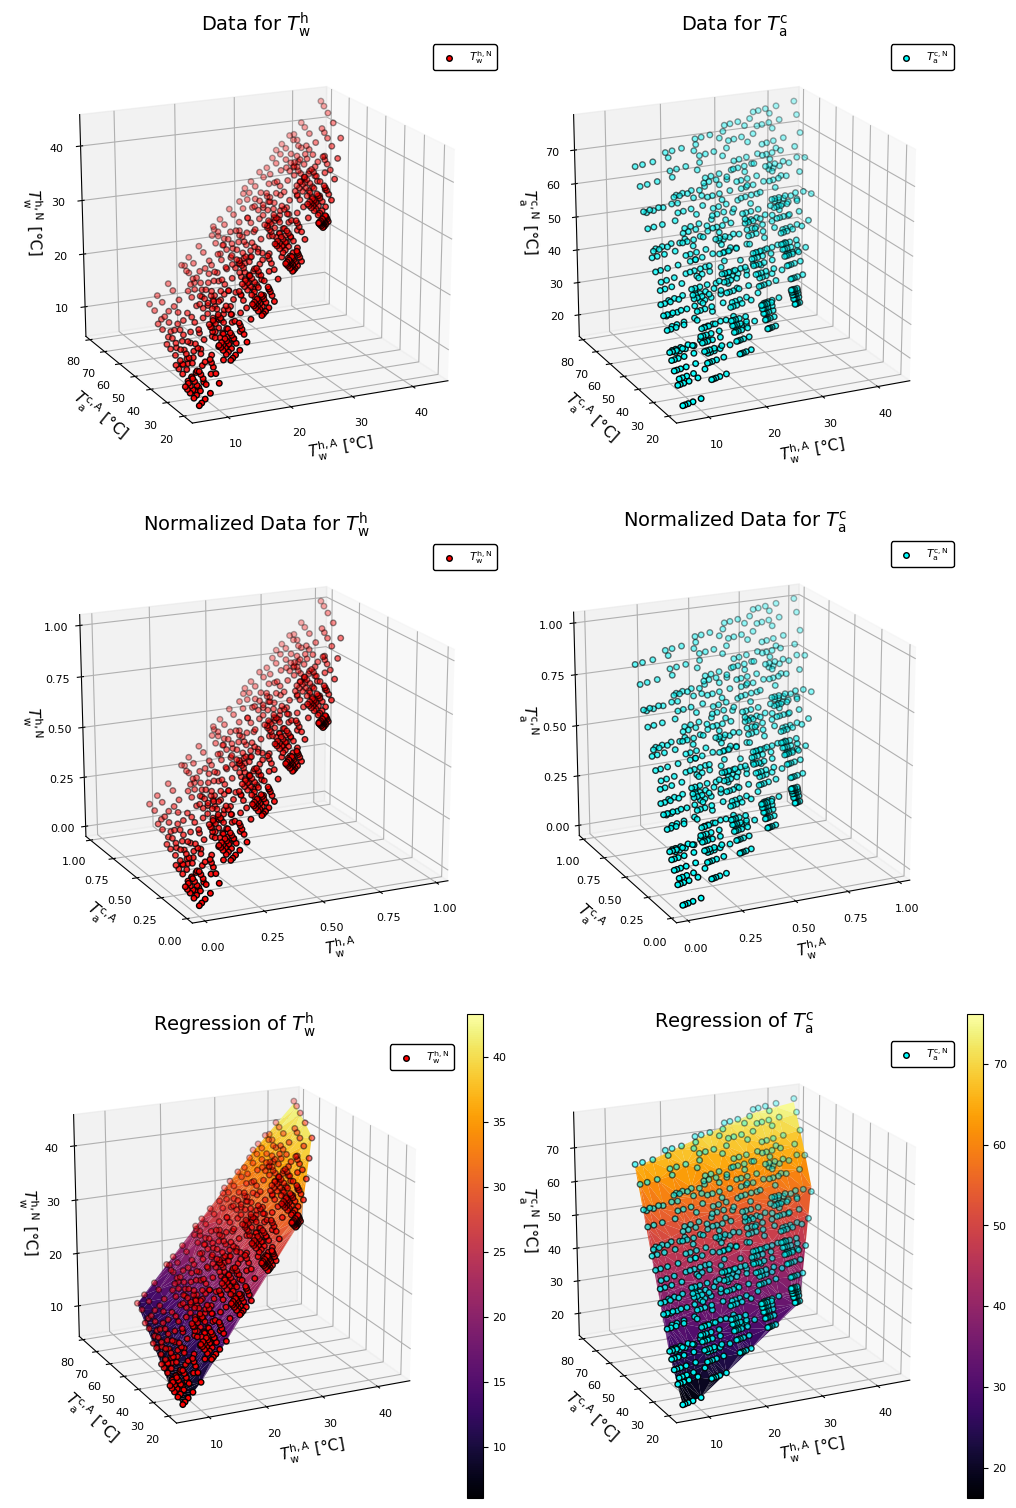

In [25]:
scatter(X[1,:],X[2,:],Y[1,:],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"Data for $T_{\mathrm{w}}^{\mathrm{h}}$",color="red")
fg1= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ $[°\mathrm{C}]$")
scatter(X[1,:],X[2,:],Y[2,:],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"Data for $T_{\mathrm{a}}^{\mathrm{c}}$",color="#00FFFF")
fg2= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ $[°\mathrm{C}]$")
#
scatter(Xn[1,:],Xn[2,:],Yn[1,:],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"Normalized Data for $T_{\mathrm{w}}^{\mathrm{h}}$",color="red")
fg3= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$")
scatter(Xn[1,:],Xn[2,:],Yn[2,:],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"Normalized Data for $T_{\mathrm{a}}^{\mathrm{c}}$",color="#00FFFF")
fg4= scatter!(xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$")
#
plot(X[1,:],X[2,:],Y_hat[1,:],seriestype=:surface,camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"Regression of $T_{\mathrm{w}}^{\mathrm{h}}$")
fg5= scatter!(X[1,:],X[2,:],Y[1,:],xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ $[°\mathrm{C}]$",color="red",label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$")
plot(X[1,:],X[2,:],Y_hat[2,:],seriestype=:surface,camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"Regression of $T_{\mathrm{a}}^{\mathrm{c}}$")
fg6= scatter!(X[1,:],X[2,:],Y[2,:],xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ $[°\mathrm{C}]$",color="#00FFFF",label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$")
#
plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm)
Figname = "Data_before_and_after_normalization.svg"
savefig(Figpath*Figname)

##### Saving model

In [56]:
# @save "File_name.bson" model

### Multiple Holdout
The best-fit output (`out`) size can be found through trial and error using the functions `multiple_Holdout` and `multiple_Holdout_c3_b`
#### Case III (A)

In [28]:
Avg_RMSE_Y1_c3_a,Avg_RMSE_Y2_c3_a = multiple_Holdout(TTAgrid_c3_a,TTNgrid_c3_a,[5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100],ngrid,0.50,3,10000)

1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20 done

1 sample out of 3 done


1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20

([0.29929269117010177 0.26270001025671674 … 0.24557579042312008 0.3181157961055782], [0.8258454122681121 0.8685605802043598 … 0.8271445007052883 0.9126537735149721])

#### Case III: (C) Same as case (3.a), except data is generated for a wider range. The goal here is to compare the goodness of fit with nonlinear regression later on.
##### Generating the dataset

In [29]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,40.,length=n_Tw)
r_Tah = range(15.,130.,length=n_Ta)
r_mdw = range(15.,130.,length=n_mdw)
r_mda = range(15.,130.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_c = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c3_c = Matrix{Float64}(undef,2,ngrid)
;

In [30]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_c[:,i] .= [sol_analytic[end][1],sol_analytic[1][2]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_c[:,i] .= [sol_numeric[end][1],sol_numeric[1][2]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:21:00


In [31]:
Avg_RMSE_Y1_c3_c,Avg_RMSE_Y2_c3_c = multiple_Holdout(TTAgrid_c3_c,TTNgrid_c3_c,[5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100],ngrid,0.50,3,10000)

1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20 done

1 sample out of 3 done


1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20

([0.598998285076879 0.46075964571639766 … 0.3692922264888778 0.49101403284816775], [1.3648554341004966 1.3383858996566798 … 1.239938631422822 1.397849644057759])

#### Case III: (B) Same as the previous case, except that the mass flow rates are also regressors. Similarly, the goal here is to evaluate the impact of mass flow rate on the goodness-of-fit.
##### Generating the dataset

In [32]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,40.,length=n_Tw)
r_Tah = range(15.,130.,length=n_Ta)
r_mdw = range(15.,130.,length=n_mdw)
r_mda = range(15.,130.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_b = Matrix{Float64}(undef,4,ngrid) # dimension 2xngrid
TTNgrid_c3_b = Matrix{Float64}(undef,2,ngrid)
;

In [33]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_b[:,i] .= [sol_analytic[end][1],sol_analytic[1][2],mdw,mda]
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_b[:,i] .= [sol_numeric[end][1],sol_numeric[1][2]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:20:35


In [35]:
Avg_RMSE_Y1_c3_b,Avg_RMSE_Y2_c3_b = multiple_Holdout_c3_b(TTAgrid_c3_b,TTNgrid_c3_b,[5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100],ngrid,0.50,3,10000)

1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20 done

1 sample out of 3 done


1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20

([0.9645757740775537 0.45301632157235644 … 0.4521596167760844 0.5718415859885563], [1.5191245582084674 1.142841844042924 … 1.2288009073182862 1.4641582937545594])

### Plotting

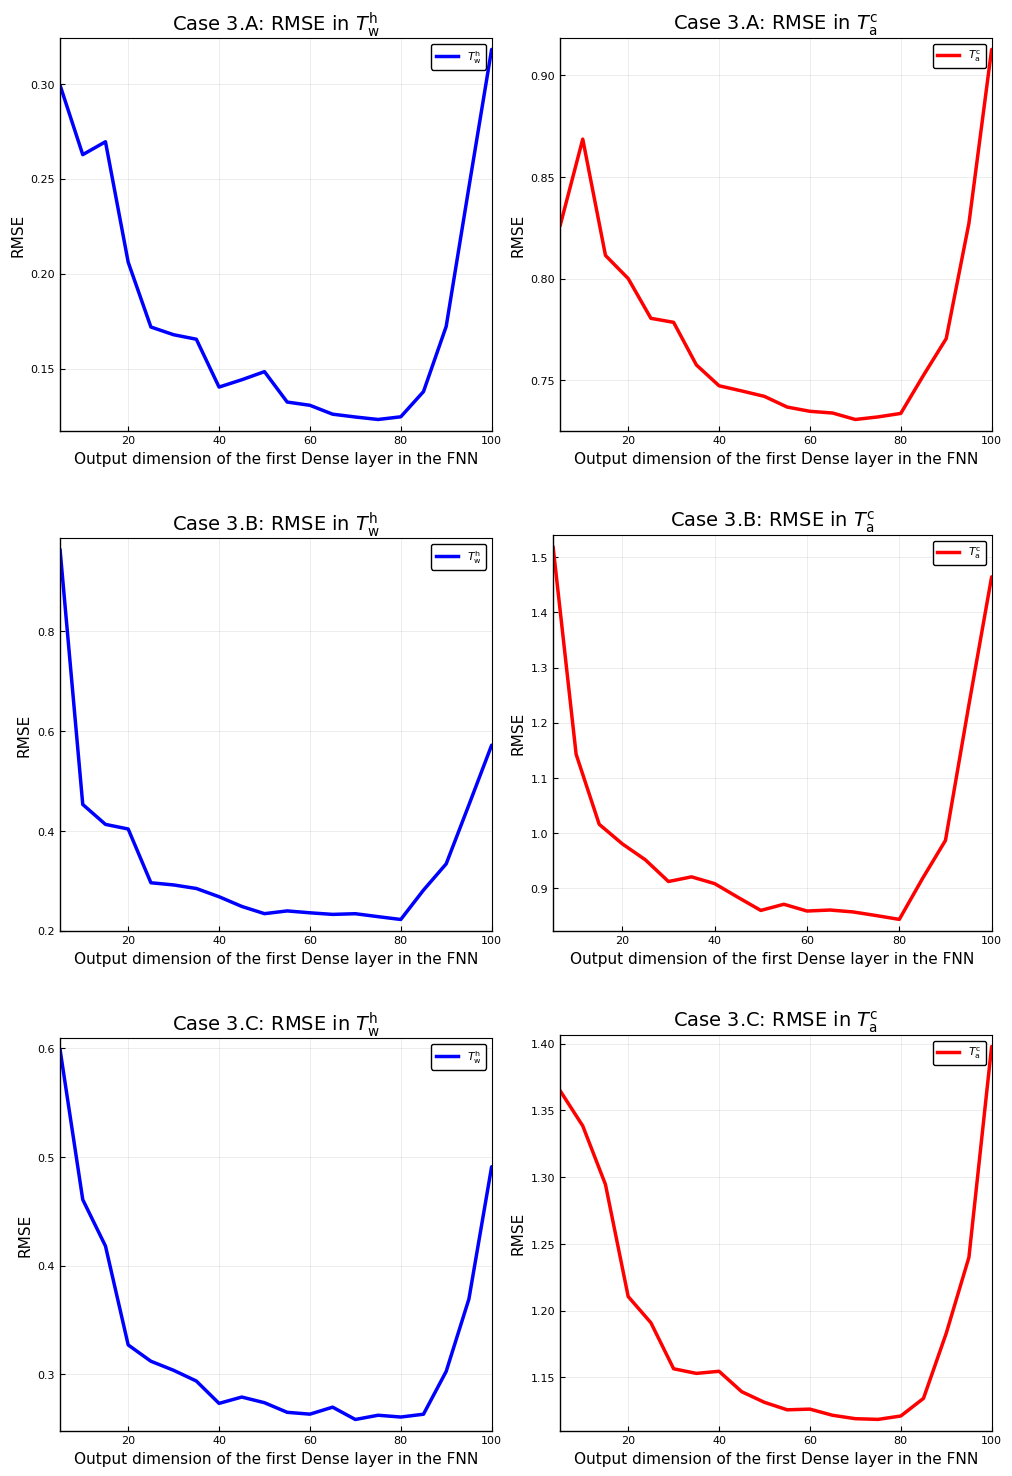

In [59]:
fg1 = plot(5:5:100,Avg_RMSE_Y1_c3_a',lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",title=L"Case 3.A: RMSE in $T_{\mathrm{w}}^{\mathrm{h}}$")
fg3 = plot(5:5:100,Avg_RMSE_Y1_c3_b',lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",title=L"Case 3.B: RMSE in $T_{\mathrm{w}}^{\mathrm{h}}$")
fg5 = plot(5:5:100,Avg_RMSE_Y1_c3_c',lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",title=L"Case 3.C: RMSE in $T_{\mathrm{w}}^{\mathrm{h}}$")
fg2 = plot(5:5:100,Avg_RMSE_Y2_c3_a',lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",title=L"Case 3.A: RMSE in $T_{\mathrm{a}}^{\mathrm{c}}$")
fg4 = plot(5:5:100,Avg_RMSE_Y2_c3_b',lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",title=L"Case 3.B: RMSE in $T_{\mathrm{a}}^{\mathrm{c}}$")
fg6 = plot(5:5:100,Avg_RMSE_Y2_c3_c',lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",title=L"Case 3.C: RMSE in $T_{\mathrm{a}}^{\mathrm{c}}$")

plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,legend=:topright,xlim=(5,100),xlabel="Output dimension of the first Dense layer in the FNN",ylabel="RMSE")
Figname = "Nonlinear_Regression.svg"
# savefig(Figpath*Figname)

## Case 4: improve the simulation time

In [27]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(3.,25.,length=n_Tw)
r_Tah = range(15.,100.,length=n_Ta)
r_mdw = range(30.,70.,length=n_mdw)
r_mda = range(30.,70.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_b_test = Matrix{Float64}(undef,4,ngrid) # dimension 2xngrid
TTNgrid_c3_b_test = Matrix{Float64}(undef,2,ngrid);

In [28]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_b_test[:,i] .= [sol_analytic[end][1],sol_analytic[1][end],mdw,mda]
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_b_test[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:19:21


In [29]:
Avg_RMSE_Y1_c3_b_test,Avg_RMSE_Y2_c3_b_test = multiple_Holdout_c3_b(TTAgrid_c3_b_test,TTNgrid_c3_b_test,[5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100],ngrid,0.50,3,10000)

1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20 done

1 sample out of 3 done


1 model out of 20 done

2 model out of 20 done

3 model out of 20 done

4 model out of 20 done

5 model out of 20 done

6 model out of 20 done

7 model out of 20 done

8 model out of 20 done

9 model out of 20 done

10 model out of 20 done

11 model out of 20 done

12 model out of 20 done

13 model out of 20 done

14 model out of 20 done

15 model out of 20 done

16 model out of 20 done

17 model out of 20 done

18 model out of 20 done

19 model out of 20 done

20 model out of 20

([0.7296911848171425 0.3090176418792385 … 0.26213271081670086 0.3764862185760272], [0.8756795040627043 0.6479984902069434 … 0.6995389706793388 0.8686049172456448])